## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

In [3]:
import pandas as pd
import math
import os

# Helper Functions

In [4]:
def show_image(image, cmap="gray", text=""):
        plt.imshow(image, cmap=cmap)
        plt.text(0,image.shape[0]*1.25,text)
        plt.show()
        
def binary_threshold_channel(channel, thresh=(90,255)):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def compute_radius_of_curvature(fit, y):
    A,B,C = fit
    return ((1 + (2*A*y + B)**2)**1.5) / np.absolute(2*A)

# Apply distortion correction to raw images.

In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import glob

In [7]:
def calibrate(path='./camera_cal/calibration*.jpg'):
    image_paths = glob.glob(path)
    imagepoints = []
    objpoints = []

    nx = 9
    ny = 6

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Convert to grayscale
    for image_path in image_paths:
        # print("processing {}".format(image_path))
        image = read_image(image_path)
        img = image.copy()

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        show_image(image, text="Gray Scale Image")

        # Find the chessboard corners
        corner_ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if corner_ret == True:
        # Draw and display the corners
            imagepoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(image, (nx, ny), corners, corner_ret)

            show_image(img, text="Distored Image")

            # * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, img.shape[1::-1], None, None)

            undistorted = cv2.undistort(img, mtx, dist, None, mtx)

            show_image(undistorted, text="Undistorted")

            src = np.float32([corners[0],corners[8],corners[35],corners[27]])

            w, h = img.shape[1::-1]

            top = 0.1; bottom = 0.55; left = 0.1; right = 0.9

            dst = np.float32([[w*left, h*top],[w*right, h*top],[w*right, h*bottom],[w*left, h*bottom]])

            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)

            # e) use cv2.warpPerspective() to warp your image to a top-down view
            warped = cv2.warpPerspective(undistorted, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
            show_image(warped, text="Perspective Warped image")

    calibration_values = {
        'imgpoints': imagepoints,
        'objpoints': objpoints,
        'mtx_distortion_correction': mtx,
        'distortion_coefficient': dist
    }
    pickle.dump(calibration_values, open( "calibration_values.p", "wb" ) )

# Single Image Test

In [8]:
from pipeline import Pipeline

In [9]:
image_list = os.listdir("./test_frames/")
image_list.remove('.DS_Store')

In [158]:
i=0

p = Pipeline()

4


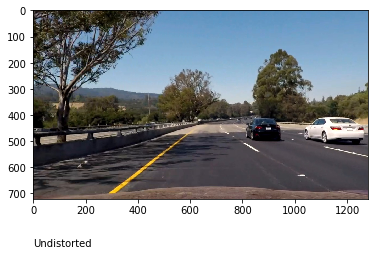

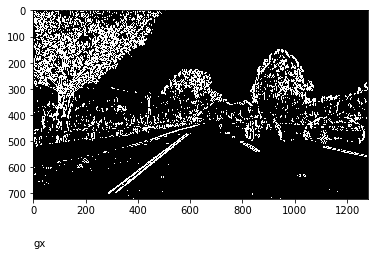

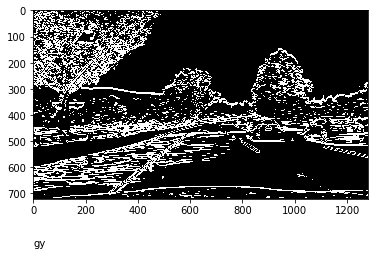

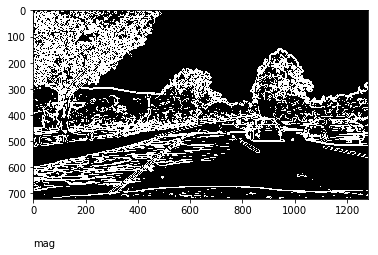

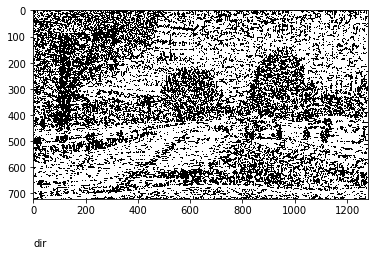

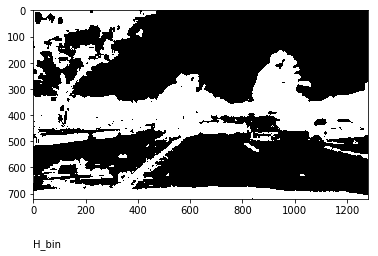

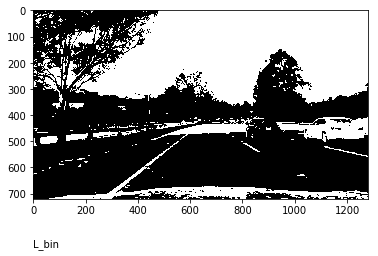

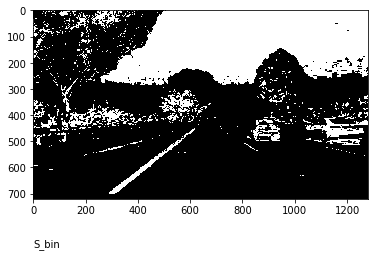

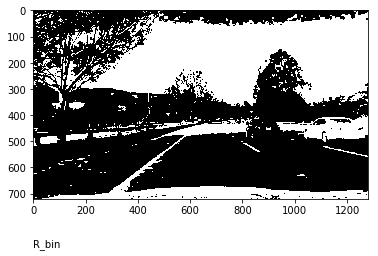

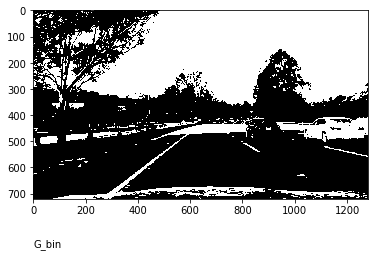

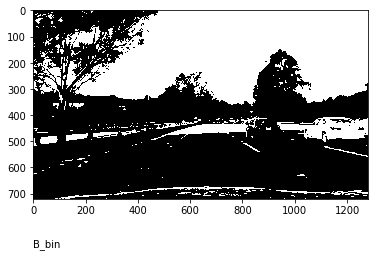

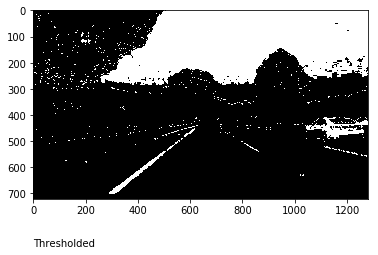

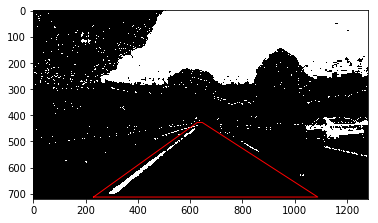

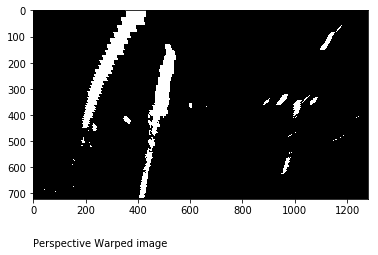

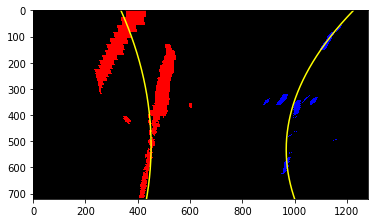

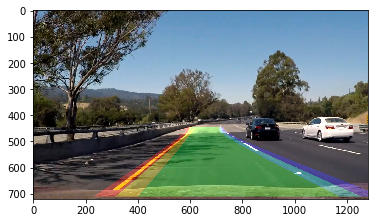

In [165]:
print(i)

image_path = image_list[i]

p.find_lanes("./test_frames/"+image_path);

i += 1

# All Test Images

In [ ]:
p = Pipeline()
for i in range(0,len(image_list)):
    image_path = image_list[i]
    p.find_lanes("./video_output/"+image_path);

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [127]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from pipeline import Pipeline
from functools import partial

def gen():
    for i in range(10,10000):
        yield i
        
g = gen()

def process_image(image, pipeline=None):
    result = pipeline.find_lanes(image, show=False)
    return result

def extract_frames(image):
    result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite('./test_frames/frame_{}.jpg'.format(next(g)),result)
    return result

pipeline = Pipeline()
detect_lanes = partial(process_image, pipeline=pipeline)

clip1 = VideoFileClip("project_video.mp4")

output_dir = "./output"
file_name = "project_video.mp4"

video_output_path = os.path.join(os.path.realpath(output_dir), file_name)

output_clip = clip1.fl_image(detect_lanes).subclip(39,41)

%time output_clip.write_videofile(video_output_path, audio=False)

[MoviePy] >>>> Building video /Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4
[MoviePy] Writing video /Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4


 98%|█████████▊| 50/51 [00:30<00:00,  1.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4 

CPU times: user 35.7 s, sys: 2.23 s, total: 37.9 s
Wall time: 31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [57]:
video_output_path

'/Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4'

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output_path))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(5,10)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4')
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))